# Machine Learning - Lab
### Find the best clustering with __DBSCAN__
# Tasks
Find the clusters in the included dataset.

The solution must be produced as a Python Notebook. The notebook must include appropriate comments and must produce:

1. the boxplots of the attributes and a comment on remarkable situations, if any (2pt)
1. a pairplot of the data (see Seaborn pairplot) and a comment on remarkable situations, if any (2pt)
1. a clustering schema using a method of your choice exploring a range of parameter values (5pt)
1. the plot of the global inertia (SSD) and silhouette index for the parameter values you examine  (4pt)
1. the optimal parameters of your choice (4pt)
1. a pairplot of the data using as hue the cluster assignment with the optimal parameter (3pt)
1. a plot of the silhouette index for the data points, grouped according to the clusters (4pt)
1. A sorted list of the discovered clusters for decreasing sizes (7pt)

In [3]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

random_state = 42
np.random.seed(random_state)

filename = 'datasets/lab_exercise.csv'
sep = ','

# 1

In [6]:
df = pd.read_csv(filename, sep=sep, header=None)
print(f'Dataset with {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

Dataset with 1500 rows and 4 columns


,0,1,2,3
0,0.548814,-4.893751,0.365316,0.715189
1,0.602763,-0.387057,1.164867,0.544883
2,0.423655,-10.844898,-7.553523,0.645894
3,0.437587,1.975564,-1.274422,0.891773
4,0.963663,-4.054276,0.064053,0.383442


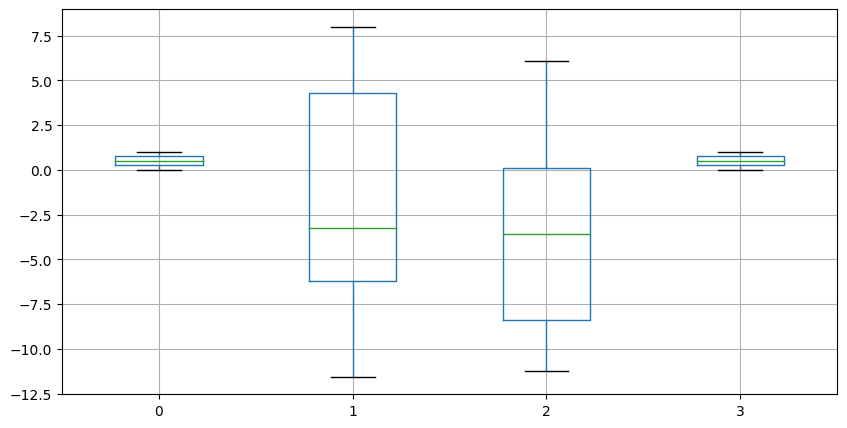

In [8]:
df.boxplot(figsize=(10, 5));

Columns 0 and 3 have a range much smaller than 1 and 2. The distributions onf 0 and 3 seem to be equal. Possibly, a min-max rescaling could point out some additional insight.


# 2

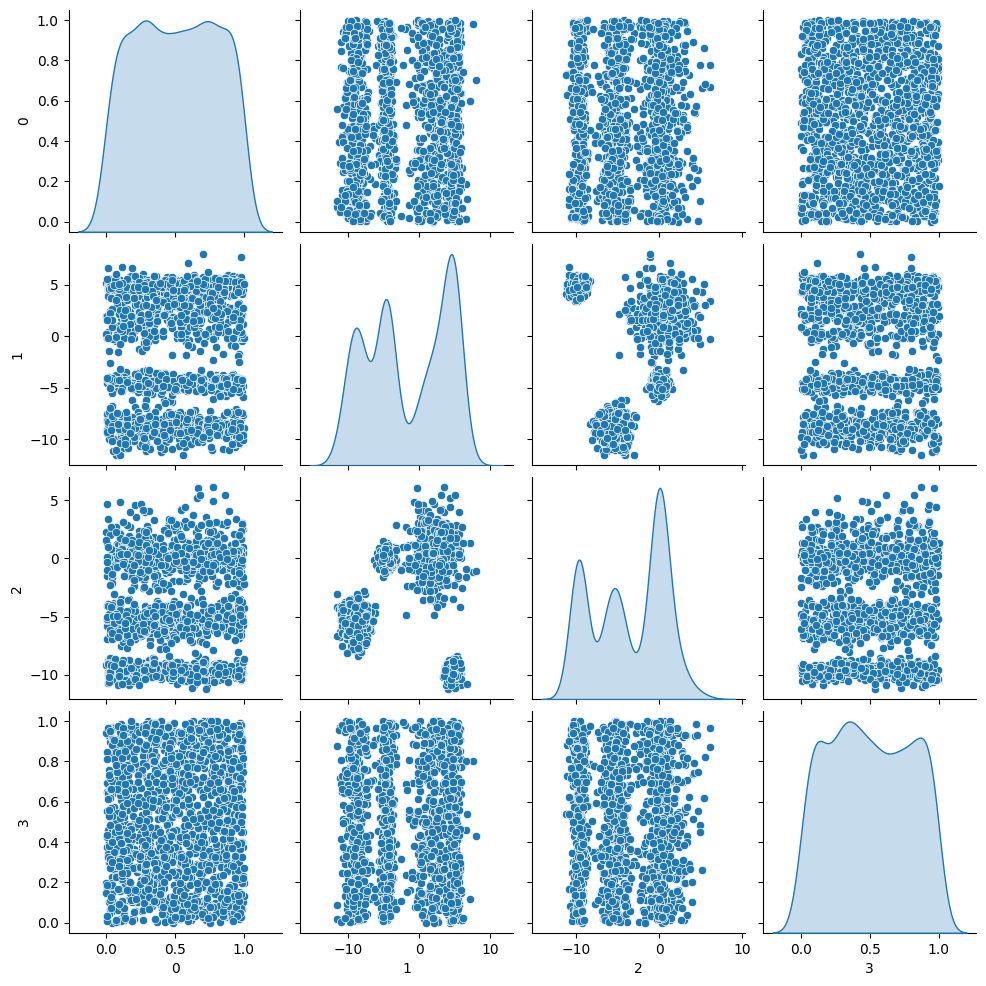

In [9]:
sns.pairplot(df, diag_kind='kde');

The pairplots of `0` and `3` show that those columns are uniformly distributed and do not show any pattern.

In [10]:
in_cols = [1,2]

# 3

In [12]:
db = DBSCAN()
y_db = db.fit_predict(df)

In [17]:
cluster_labels_all = np.unique(y_db)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)

if cluster_labels_all[0] == -1:
    print('There is noise')
else:
    print('There are {} clusters'.format(n_clusters))

There is noise


In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_clusters(X, y, dim, points,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.tab10, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(10) # by default the last of the map (to be improved)
                 ):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(X[y==labels[i],dim[0]], 
                    X[y==labels[i],dim[1]], 
                    s=10, 
                    c = [color], # scatter requires a sequence of colors
                    marker='s', 
                    label=labels_prefix+str(labels[i]))
    plt.scatter(points[:,dim[0]], 
                points[:,dim[1]], 
                s=50, 
                marker='*', 
                c=[points_color], 
                label=points_name)
    plt.legend()
    plt.grid()
    plt.show()

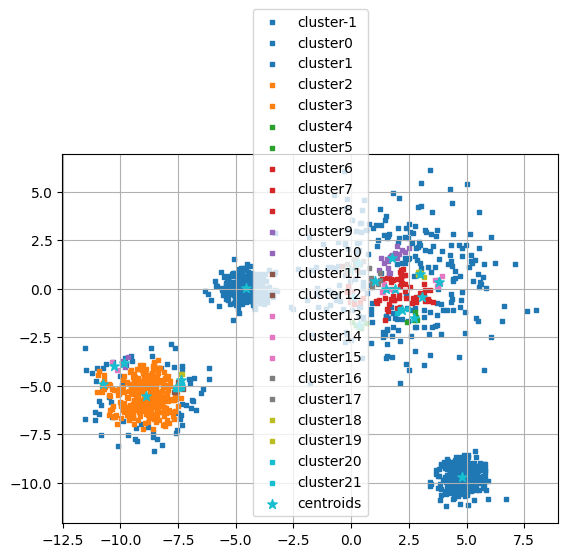

In [20]:
cluster_centers = np.empty((n_clusters, df.shape[1]))

for i in cluster_labels:
    cluster_centers[i,:] = df[y_db == i].mean(axis=0)

plot_clusters(df.values, y_db, (1,2), cluster_centers)

In [21]:
param_grid = {
    'eps': list(np.arange(0.1, 2, 0.1)),
    'min_samples': list(range(3, 10))
}

params = ParameterGrid(param_grid)
sil_thr = 0.7
clust_thr = 0.5

In [22]:
def inertia_and_centers(X, y):
    ''' Computes the centroids and the inertia given a set of points X and labels y
        Parameters:
        X   : an array of shape[0] points in shape[1] dimensions
        y   : a vector of labels corresponding to the points, proper labels
              are in range 0..(shape[0]-1); possibly noise points are labelled -1
        Uses the 'Einstein summation convention' from numpy for fast computation of 
        the inertia, see the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html#numpy.einsum)
    '''
    cluster_labels_all = np.unique(y)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    cluster_centers = np.empty((n_clusters,X.shape[1]))
    inertia = 0
    for i in cluster_labels:
        X_i = X[y==i,:]
        cluster_centers[i,:] = np.mean(X_i, axis = 0)
        X_i -= cluster_centers[i,:]
        inertia += np.einsum('ij,ij',X_i,X_i)
    return inertia, cluster_centers, n_clusters    

In [27]:
results = pd.DataFrame(columns=['eps','min_samp',
                                'n_clust','silh', 'clust_f', 'sc_index', 'inertia'])    
X = np.loadtxt(filename, delimiter=sep)
import warnings
warnings.filterwarnings('ignore')
for p in params:
    db = DBSCAN(**p)
    y_db = db.fit_predict(df)
    inertia, cluster_centers, n_clusters = inertia_and_centers(df.values, y_db)
    X_cl = X[y_db != -1,:]
    y_db_cl = y_db[y_db != -1]
    if n_clusters > 1:
        sil = silhouette_score(X_cl, y_db_cl)
    else:
        sil = -2
    clust = y_db_cl.shape[0] / y_db.shape[0]
    sc_index = sil * clust/(sil + clust)
    if sil > sil_thr and clust > clust_thr:
        results = results.append({
            'eps': db.eps,
            'min_samp': db.min_samples,
            'n_clust': n_clusters,
            'silh': sil,
            'clust_f': clust,
            'sc_index': sc_index,
            'inertia': inertia
        }, ignore_index=True)

results

,eps,min_samp,n_clust,silh,clust_f,sc_index,inertia
0,0.4,6.0,7.0,0.730719,0.560667,0.317248,465.390843
1,0.4,7.0,5.0,0.770945,0.530000,0.314080,415.347170
2,0.4,8.0,6.0,0.785651,0.502667,0.306540,379.082668
3,0.5,8.0,7.0,0.712611,0.660667,0.342828,666.544150
4,0.5,9.0,6.0,0.705684,0.634000,0.333962,615.012194
5,0.6,7.0,9.0,0.725147,0.815333,0.383800,1151.123928
6,0.6,8.0,7.0,0.756750,0.785333,0.385388,1064.851658
7,0.6,9.0,7.0,0.779802,0.764667,0.386080,1000.913915
8,0.7,7.0,6.0,0.702986,0.912667,0.397110,1966.819464
9,0.7,8.0,6.0,0.711260,0.901333,0.397547,1892.885231


# 4

In [28]:
idx_max_silh = results.groupby(['n_clust'])['silh'].transform(max) == results['silh']


In [29]:
top_results = results[idx_max_silh].sort_values('n_clust')


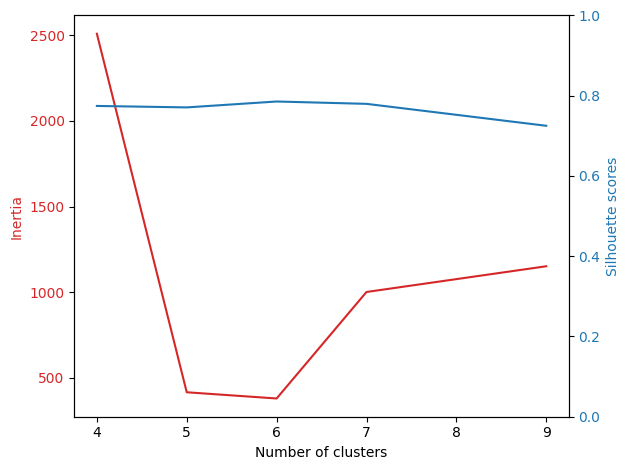

In [30]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(top_results['n_clust'].values, top_results['inertia'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(top_results['n_clust'].values, top_results['silh'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

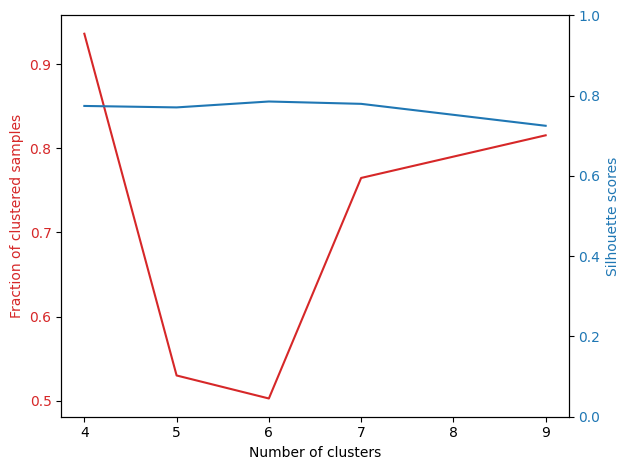

In [31]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Fraction of clustered samples', color=color)
ax1.plot(top_results['n_clust'].values, top_results['clust_f'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(top_results['n_clust'].values, top_results['silh'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

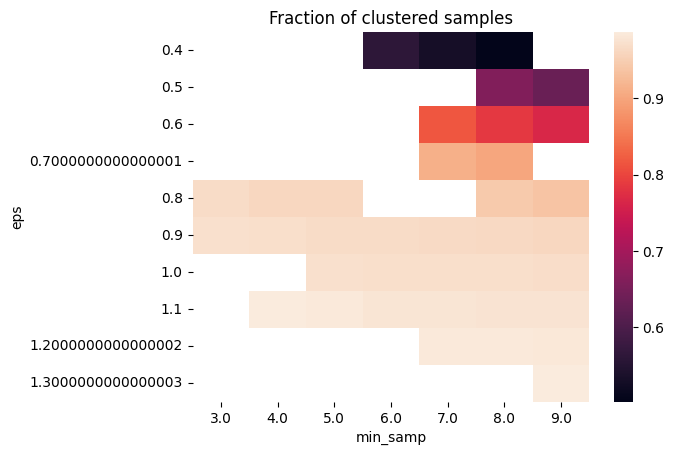

In [32]:
results_pivot =results.pivot('eps', 'min_samp', 'clust_f')
plt.title("Fraction of clustered samples")
ax = sns.heatmap(results_pivot)

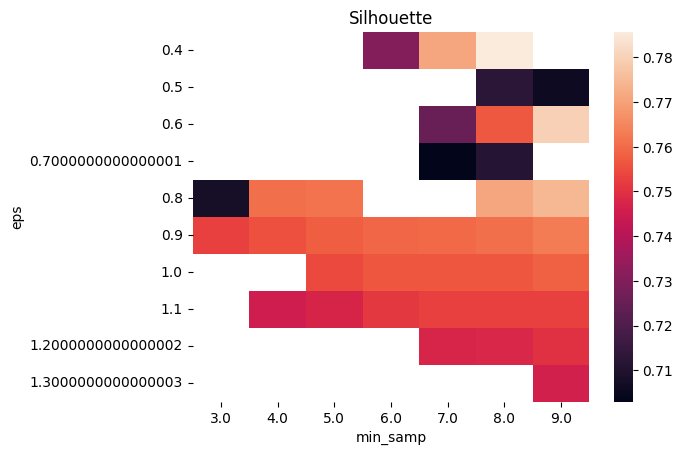

In [33]:
import seaborn as sns
results_pivot =results.pivot('eps', 'min_samp', 'silh')
plt.title("Silhouette")
ax = sns.heatmap(results_pivot)

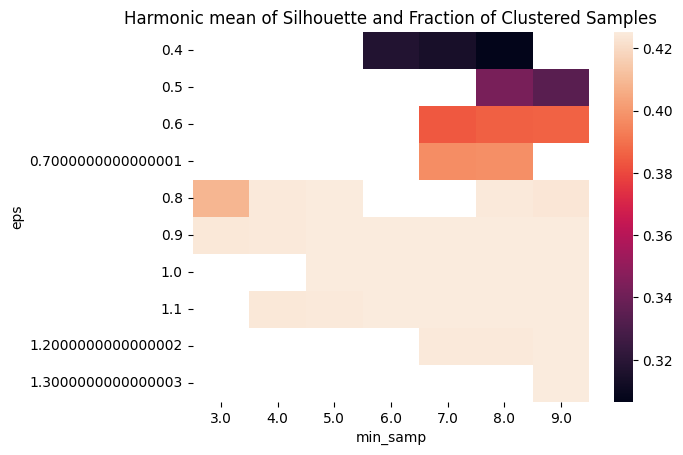

In [34]:
results_pivot =results.pivot('eps', 'min_samp', 'sc_index')
plt.title("Harmonic mean of Silhouette and Fraction of Clustered Samples")
ax = sns.heatmap(results_pivot)

# 5

In [35]:
best = results.iloc[results['sc_index'].argmax()]

In [36]:
print("Best tradeoff between Silhouette and Fraction of Clustered")
print("EPS = {:3.2f}\tMIN_SAMPLES = {:2.0f}".format(best.eps, best.min_samp))
print("Results with best parameters")
print("Silhouette = {:3.2f}\tClustered Fraction = {:3.2f}\tNumber of Clusters = {:2.0f}".\
      format(best.silh, best.clust_f,best.n_clust))

Best tradeoff between Silhouette and Fraction of Clustered
EPS = 0.90	MIN_SAMPLES =  9
Results with best parameters
Silhouette = 0.76	Clustered Fraction = 0.96	Number of Clusters =  4


# 6

In [39]:
db = DBSCAN(eps=best.eps, min_samples=int(best.min_samp))
y_db = db.fit_predict(df)

In [40]:
df['cluster'] = y_db

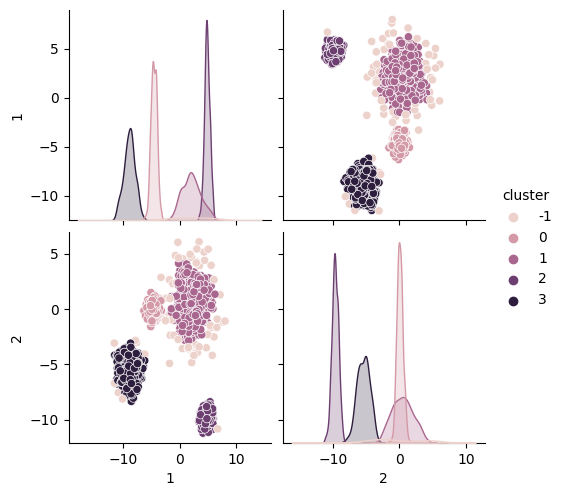

In [42]:
sns.pairplot(df[in_cols + ['cluster']], hue='cluster', vars=df.columns[in_cols]);

# 7

In [43]:
from matplotlib import cm
def plot_silhouette(silhouette_vals, y, colors = cm.tab10, plot_noise = False):
    """
    Plotting silhouette scores for the individual samples of a labelled data set.
    The scores will be grouped according to labels and sorted in descending order.
    The bars are proportional to the score and the color is determined by the label.
    
    silhouette_vals: the silhouette values of the samples
    y:               the labels of the samples
    plot_noise:      boolean, assumes the noise to be labeled with a negative integer
    
    """
    cluster_labels = np.unique(y)
    n_clusters = len(cluster_labels)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels): # generate pairs index, cluster_label
        if (c < 0 and plot_noise == False):
            continue
        c_silhouette_vals = silhouette_vals[y==c] # extracts records with the current cluster label
        c_silhouette_vals.sort() # sort the silhouette vals for the current class
        y_ax_upper += len(c_silhouette_vals)
        color = colors(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
        c_silhouette_avg = np.mean(c_silhouette_vals)
        plt.axvline(c_silhouette_avg, #ymin = y_ax_lower, ymax = y_ax_upper,
                    color=color, linestyle="-.")

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="black", linestyle=":") 
    plt.yticks(yticks, cluster_labels)# + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    # plt.savefig('./figures/silhouette.png', dpi=300)
    plt.show()

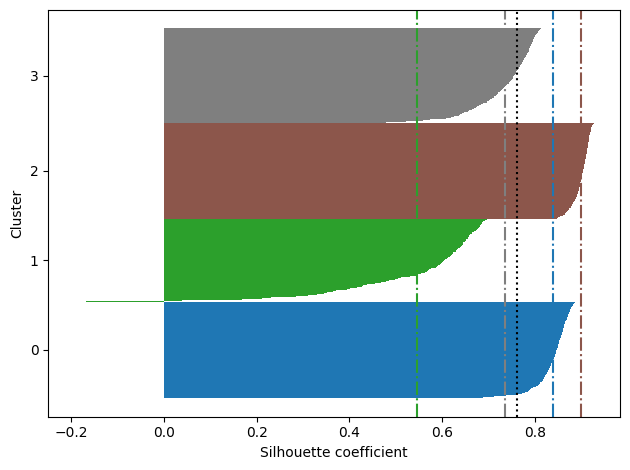

In [44]:
X_cl = X[y_db!=-1,:]
y_db_cl = y_db[y_db!=-1]
silhouette = silhouette_samples(X_cl,y_db_cl)
plot_silhouette(silhouette,y_db_cl)
# silhouette = silhouette_samples(X,y_db)
# plot_silhouette(silhouette,y_db)

# 8

In [45]:
counts = pd.DataFrame(y_db).groupby(0).size().reset_index(name='Count')
counts = counts.rename(columns = {0: 'Cluster'}).sort_values(by = 'Count', ascending = False)
counts

,Cluster,Count
1,0,375
3,2,374
4,3,368
2,1,324
0,-1,59
